In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import string
from collections import defaultdict

In [2]:
plt.rcParams["font.size"] = 16
SHOW_RG = False

In [3]:
with open("pg_run_job_light.txt") as f:
    data = f.read().split("\n")[2:]
data = [x.split(" ") for x in data if len(x) > 1 and (x[0] in string.digits or x[0] == "x")]

data = [(x[0], x[1], float(x[2]), x[3], float(x[4])) for x in data]
pg_data = data
pg_times = np.array([x[2] for x in pg_data])
pg_times -= np.min(pg_times)
pg_times /= 60


def read_bao_data(fp):
    with open(fp) as f:
        data = f.read().split("\n")[2:]

    training_times = []
    for idx in range(len(data)):
        if data[idx].strip().startswith("Initial input channels"):
            prev_line = data[idx-1].split(" ")
            if prev_line[0] == "Retry":
                continue
            training_times.append(float(prev_line[2]))


    training_times = np.array(training_times)

    data = [x.split(" ") for x in data if len(x) > 1 and (x[0] in string.digits or x[0] == "x")]
    data = [(x[0], x[1], float(x[2]), x[3], float(x[4])) for x in data]
    bao_data = data

    bao_times = np.array([x[2] for x in bao_data])
    training_times -= np.min(bao_times)
    bao_times -= np.min(bao_times)

    bao_times /= 60
    training_times /= 60
    return bao_data, bao_times, training_times

bao_data, bao_times, training_times = read_bao_data("bao_run_job_light.txt")
if SHOW_RG:
    bao_rb_data, bao_rb_times, training_rb_times = read_bao_data("bao_with_regblock.txt")

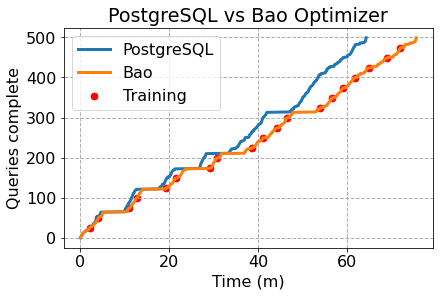

In [4]:
queries_complete = np.arange(0, len(pg_times))

fig, ax = plt.subplots(1, 1, constrained_layout=True)


train_y = []
train_rb_y = []
for tt in training_times:
    idx = np.searchsorted(bao_times, tt)
    train_y.append(idx)
    
if SHOW_RG:
    for tt in training_rb_times:
        idx = np.searchsorted(bao_rb_times, tt)
        train_rb_y.append(idx)
    
plt.scatter(training_times, train_y, s=45, color="red", label="Training")

ax.plot(pg_times, queries_complete, label="PostgreSQL", lw=3)
ax.plot(bao_times, queries_complete, label="Bao", lw=3)

if SHOW_RG:
    plt.scatter(training_rb_times, train_rb_y, s=45, color="red")
    ax.plot(bao_rb_times, queries_complete, label="Bao (w/ exploration)", lw=3)

ax.set_xlabel("Time (m)")
ax.set_ylabel("Queries complete")
ax.set_title("PostgreSQL vs Bao Optimizer")

ax.grid(linestyle="--", linewidth=1)
ax.legend()
# fig.savefig("queries_vs_time.svg")

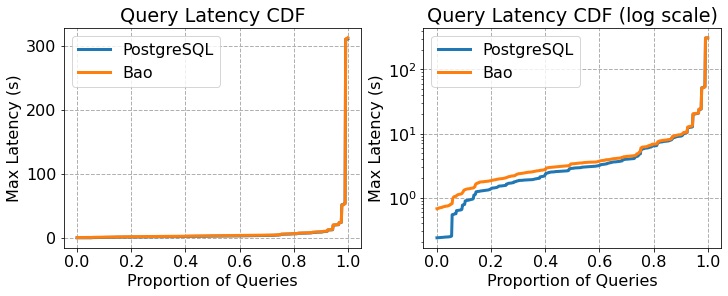

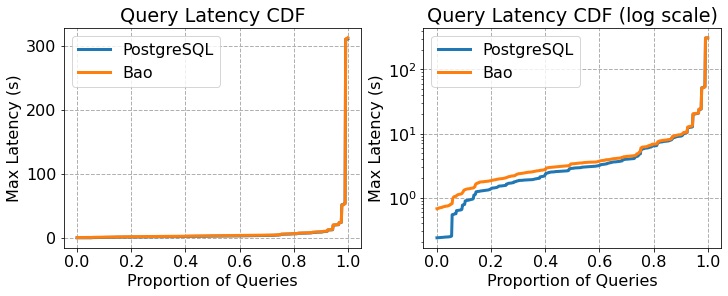

In [5]:
all_pg_times = sorted([x[4] for x in pg_data])
all_bao_times = sorted([x[4] for x in bao_data])

if SHOW_RG:
    all_bao_rb_times = sorted([x[4] for x in bao_rb_data])


fig, axes = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)

ax = axes[0]
ax.plot(np.linspace(0, 1, len(all_pg_times)), all_pg_times, lw=3, label="PostgreSQL")
ax.plot(np.linspace(0, 1, len(all_pg_times)), all_bao_times, lw=3, label="Bao")

if SHOW_RG:
    ax.plot(np.linspace(0, 1, len(all_pg_times)), all_bao_rb_times, lw=3, label="Bao (w/ exploration)")

ax.grid(linestyle="--", linewidth=1)
ax.set_xlabel("Proportion of Queries")
ax.set_ylabel("Max Latency (s)")
ax.set_title("Query Latency CDF")
ax.legend()
#ax.set_yscale("log")


ax = axes[1]
ax.plot(np.linspace(0, 1, len(all_pg_times)), all_pg_times, lw=3, label="PostgreSQL")
ax.plot(np.linspace(0, 1, len(all_pg_times)), all_bao_times, lw=3, label="Bao")

if SHOW_RG:
    ax.plot(np.linspace(0, 1, len(all_pg_times)), all_bao_rb_times, lw=3, label="Bao (w/ exploration)")

ax.grid(linestyle="--", linewidth=1)
ax.set_xlabel("Proportion of Queries")
ax.set_ylabel("Max Latency (s)")
ax.set_title("Query Latency CDF (log scale)")
ax.legend()
ax.set_yscale("log")
# fig.savefig("cdf.svg")
fig

In [6]:
# get the last PG time for each query
pg_query_time = {}
for itm in pg_data:
    pg_query_time[itm[3]] = itm[4]
        
# get each Bao time
bao_query_times = defaultdict(list)
for itm in bao_data[50:]:
    bao_query_times[itm[3]].append(itm[4])
    
if SHOW_RG:
    # get each Bao time
    bao_rb_query_times = defaultdict(list)
    for itm in bao_rb_data[50:]:
        bao_rb_query_times[itm[3]].append(itm[4])

max_repeats = max(len(x) for x in bao_query_times.values())

def extract_q_number(x):
    return int(x[x.find("/q")+2:x.find("_", x.find("/q"))])

q_order = sorted(bao_query_times.keys(), key=extract_q_number)

grid = [bao_query_times[x] for x in q_order]

if SHOW_RG:
    grid_rb = [bao_rb_query_times[x] for x in q_order]


reg_data = []
for idx, q in enumerate(q_order):
    if SHOW_RG:
        reg_data.append({"Q": f"q{extract_q_number(q)}", 
                         "PG": pg_query_time[q],
                         "Bao worst": max(grid[idx]),
                         "Bao best": min(grid[idx]),
                         "Bao + E worst": max(grid_rb[idx]),
                         "Bao + E best": min(grid_rb[idx])})
    else:
        reg_data.append({"Q": f"q{extract_q_number(q)}", 
                 "PG": pg_query_time[q],
                 "Bao worst": max(grid[idx]),
                 "Bao best": min(grid[idx])})
                


def color_regression(col):
    def c_for_diff(diff):
        if diff < 2 and diff > -2:
            return "background-color: white"
        elif diff > 0.5:
            return "background-color: #f27281"
        else:
            return "background-color: #9ee3ad"
        
    to_r = [""]
    
    if SHOW_RG:
        pg, bao_worst, bao_best, bao_rg_worst, bao_rg_best = col
    else:
        pg, bao_worst, bao_best = col

    
    to_r.append(c_for_diff(bao_worst - pg))
    to_r.append(c_for_diff(bao_best - pg))
    
    if SHOW_RG:
        to_r.append(c_for_diff(bao_rg_worst - pg))    
        to_r.append(c_for_diff(bao_rg_best - pg))

    return to_r

reg_data = pd.DataFrame(reg_data).set_index("Q")
reg_data.style.apply(color_regression, axis=1)

ValueError: invalid literal for int() with base 10: 'ob-light-queries/32.sq'